# Validation Notes

For the last few weeks we have split the dataset into 3 sets, training, test and validation as described in lecture 2 slides 21-24. I did it this way to emphasise how the test set should be used. I also wanted you to see something with confusion_matrix and classification_reports which are easier to do this way.

However, this is not always the best way of doing things, particularly if we have limited data. A better way of doing things is to use a cross-validation score to make decisions instead.

So here's the idea
1. Split the data into training and test data (2 sets)
2. With the training data, try and come up with a final model
3. Score any type of model you build using a cross-validation score, either use kFolds, cross_val_score or GridSearchCV
4. Your final model hyperparameters is the one with the highest cross-validation score
5. With the final chosen model, evaluate it on the test set (classification_report as well as everything else)

With cross_val_score, you don't have to only rely on accuracy, that is just the default, look at the manual https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html or cross_val_score? . You can get different f1 scores

| F1 Type     | Best for                          | Handles Imbalance? | Formula Basis              |
|------------|----------------------------------|------------------|----------------------------|
| **Macro**  | Equal importance to all classes  | ❌ No            | Mean of per-class F1       |
| **Weighted** | Reflects dataset distribution  | ✅ Yes           | Weighted mean of per-class F1 |
| **Micro**  | Overall accuracy-based evaluation | ✅ Yes           | Global precision & recall  |

f1_macro, f1_weighted, f1_micro setting the scoring attribute in cross_val_score. Similar in GridSearchCV

# Face Recognition

In this lab we are going to build a facial recognition model using Support Vector Machines. The state of the art for image processing is to use Convolutional Neural Networks, but we'll try SVMs now to see how they do

fetch_lfw_people can get us these images. We will take all the people in the dataset that have at least 60 images of that person. This may take a while to run as it will download the images

In [65]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60, resize=1)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 125, 94)


So we have 8 different people to train our model on and 1348 total images. The image resolution is 125x94

In [66]:
faces.data.shape

(1348, 11750)

Why does this have shape 1348, 11750?

In [67]:
125*94

11750

Let's check how many we have of each person

In [68]:
#added imports
import numpy as np
import matplotlib.pyplot as plt

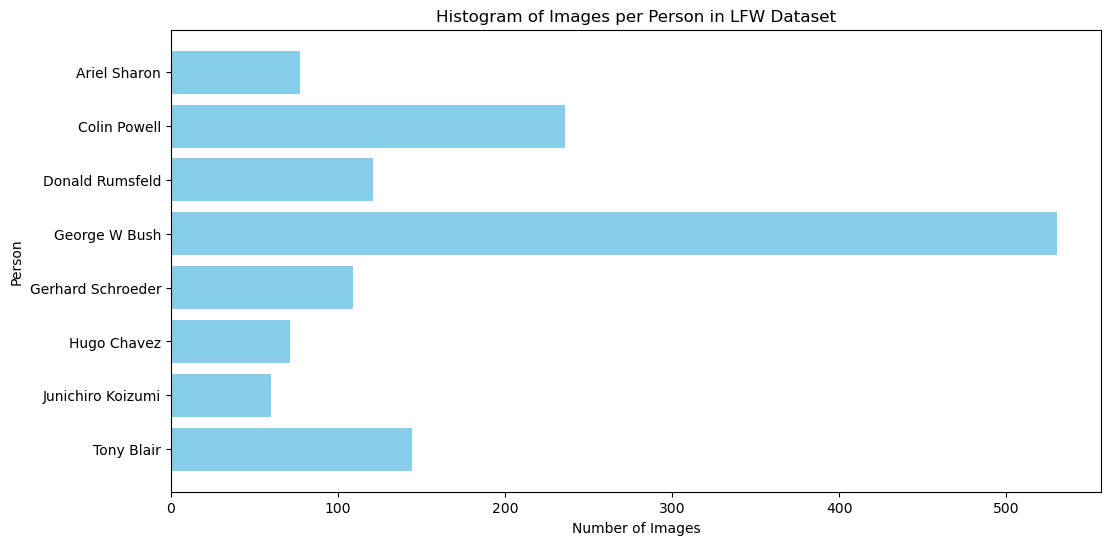

In [69]:
# Count images per person
unique_people, counts = np.unique(faces.target, return_counts=True)

# Get corresponding names
person_names = [faces.target_names[i] for i in unique_people]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.barh(person_names, counts, color='skyblue')
plt.xlabel("Number of Images")
plt.ylabel("Person")
plt.title("Histogram of Images per Person in LFW Dataset")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Is this a balanced set?

Let's set up our X and Y. faces.data and faces.target seem like good places to go!

In [70]:
# your code here
X = faces.data
y = faces.target

In [71]:
X[0]

array([0.5254902 , 0.5176471 , 0.5058824 , ..., 0.00653595, 0.00261438,
       0.        ], dtype=float32)

shows the images are greyscale with values between 0 and 1 it looks like

Do a train test split as usual, use a random_state

In [72]:
# your code here
from sklearn.model_selection import train_test_split

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=42)

In [73]:
# your code here

# print the output
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (1011, 11750)
X_val shape: (252, 11750)


Do a quick test with things we know, build and test a SVM linear model with C=2, a SVM rbf model with C=2, a LogisticRegression model and a kNN neighbours model with n=5

In [90]:
# import the model types
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [103]:
model = SVC(kernel='linear', C=2.0)
%time cross_val_score(model, X_train, y_train)
%time model.fit(X_train, y_train)

CPU times: total: 59.9 s
Wall time: 10.2 s
CPU times: total: 13.8 s
Wall time: 2.31 s


SVC(C=2.0, kernel='linear')

In [92]:
# knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#evaluate the model
train_score = knn.score(X_train, y_train)
val_score = knn.score(X_val, y_val)
print(f"Training Accuracy: {train_score:.4f}")
print(f"Validation Accuracy: {val_score:.4f}")

#count incorrect predictions on test set
y_pred = knn.predict(X_test)
incorrect_predictions = (y_pred != y_test).sum()
print(f"Incorrect predictions: {incorrect_predictions}")

Training Accuracy: 0.7062
Validation Accuracy: 0.5397
Incorrect predictions: 41


In [100]:
# logisticregression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Validation score: ", model.score(X_val, y_val))

Validation score:  0.8412698412698413


In [94]:
# rbf SVC


### My results

When I ran it, LogisticRegression got the best test score (but took ages to run, 2 and a half minutes!) , then SVC with a linear kernel, then SVC with an rbf kernel (all relatively close scores) and finally kNN was a good bit behind

SVC likes things to be normalised, although the fact that these are images with values between 0 and 1 already means this may not really do much, and maybe with images, it should not even be attempted!

In [95]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

In [96]:
# your code here 

model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.5294117647058824


A small improvement with StandardScaler

## Cross Validation
Now let's concentrate on SVC and pick the best one we can with that dataset. Import GridSearchCV and use that

In [111]:
# your code here
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


You're going to want to try different values of C, different gammas and different kernels (linear, rbf, poly)

While you can do them all in one param_grid, it might take longer as it will go through hyperparameters that have no affect on some kernels wasting time

Look at the breast cancer example for how I approached it there

In [112]:
# your code goes after here
svclass = SVC(kernel='linear')

In [114]:
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100, 1000, 10000]

n_folds=5
count = 0
train_scores = np.zeros((len(Cs),n_folds))
valid_scores = np.zeros((len(Cs),n_folds))
kf = KFold(n_splits=n_folds, shuffle=False)
for i in Cs:
    fold = 0
    print(i)
        
    for train_index, val_index in kf.split(X_train):
        X_c, X_val = X_train[train_index], X_train[val_index]
        y_c, y_val = y_train[train_index], y_train[val_index]
        est = make_pipeline(
            StandardScaler(),
            SVC(kernel='linear', C=i)
        )
        est.fit(X_c, y_c) # fit on the remaining train
        train_scores[count, fold] = est.score(X_c, y_c)
        valid_scores[count, fold] = est.score(X_val, y_val)
        fold += 1 
    count += 1

0.0001
0.001
0.01
0.1
1
2
5
10
100
1000
10000


In [115]:
train_scores.mean(axis=1)
valid_scores.mean(axis=1)

array([0.79624445, 0.83583378, 0.83286348, 0.83286348, 0.83286348,
       0.83286348, 0.83286348, 0.83286348, 0.83286348, 0.83286348,
       0.83286348])

In [122]:
model_grid = GridSearchCV(svclass, Cs)
model_grid.fit(X_train,y_train)

TypeError: Parameter grid is not a dict (0.0001)

In [117]:
param_grid = { "C" : Cs}
param_grid

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100, 1000, 10000]}

In [121]:
model_grid = GridSearchCV(svclass, param_grid=param_grid, verbose=2)
model_grid.fit(X_train, y_train)


Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] END ...........................................C=0.0001; total time=   2.4s
[CV] END ...........................................C=0.0001; total time=   2.6s
[CV] END ...........................................C=0.0001; total time=   2.5s
[CV] END ...........................................C=0.0001; total time=   2.7s
[CV] END ...........................................C=0.0001; total time=   2.6s
[CV] END ............................................C=0.001; total time=   2.6s
[CV] END ............................................C=0.001; total time=   2.8s
[CV] END ............................................C=0.001; total time=   2.5s


KeyboardInterrupt: 

Record the best score you have had with all your cross validation

You could try it all using a StandardScaler but I think it might take a lot longer to run

When you are done, take the best overall model parameters. Fit the model with the %time thing I did earlier. Same with scoring the model with the test set.

Then do a classification report and confusion matrix

Tell a story about your results, explain what you think is going on and interpret the above reports

Now try the whole thing all over again with

                    faces = fetch_lfw_people(min_faces_per_person=60, resize=0.5)

This will make the images smaller. Do you get the same or better results? It should be a lot faster training due to their being a lot less features. 

When doing train_test_split use the same random_state as you did previously, does it give you the same split then? 

Go through the same cross-validation to make your choices and do the same story with classification report/confusion matrix and timing of the fitting/scoring. This model should be faster, I don't know about the accuracy